# Instrument Response Algorithm

The [instrument_response_algorithm.py](instrument_response_algorithm.py) or Jupyter example [instrument_response_algorithm.ipynb](instrument_response_algorithm.ipynb) calculates the instrument response and
corresponding error at a single location for an `N` number of identical ball impacts. \
Firstly, run this script for all ball impacts at a given sensor location.

Import modules

In [1]:
import function_modules

import numpy as np
from scipy import signal
from scipy.fft import fft, fftfreq
import matplotlib.pyplot as plt
import pickle
import pathlib
import mpl_axes_aligner

# Download Sensor and SEM data repository
Due to repository limits, the example sensor data [sensor_data](https://doi.org/10.5683/SP3/II56AM) and simulated SEM results [SEM_data](https://doi.org/10.5683/SP3/71FAOR) must be downloaded from the [University of Toronto Dataverse](https://borealisdata.ca/dataverse/PyCalibrAE).
Both `sensor_data` and `SEM_data` directories should be placed within the working `PyCalibrAE` folder. 
1. The general simulated SEM results are in the `SEM_data` folder. These are the theoretical velocity responses (.semv) due to the Heaviside force-time function at
a given incident angle (`.POS00-90`) for the X (`.FXX`), Y (`.FXY`) and Z (`.FXZ`) components.
2. The sensor data are located within the `sensor_data` folder. A subfolder is used for a given sensor (e.g. R15a) within this folder.
Within the individual sensor folder (PyCalibrAE/R15a/), a subfolder contains all the ball impact data for that given ball size 
(e.g. PyCalibrAE/R15a/0.5mm/*.mat). The `.mat` files are the output MATLAB data files from the PicoScope 4824A data acquisition software [PicoScope 7](https://www.picotech.com/products/picoscope-7-software).
Additional information, such as the `ball_diameter` (mm), `drop_height` (cm), and acquisition `voltage_range` (V), has been manually appended to the `.mat` files.

# Input parameters

In [2]:
# Sensor and balldrop data directory
data_dir = 'sensor_data/R15a/0.66mm/'

# SEM data directory
SEM_dir = 'SEM_data/'

# Channel / incident angle to import where each letter corresponds to incident angle / sensor location on plate
# chH = 90, chG = 80, chF = 70, chE = 60, chD = 50, chC = 40, chB = 30, chA = 20, chX = 0
sensor_loc = 'chH'

## Calibration plate properties

In [3]:
modelw_p = 0.6096  # plate width (m)
modelh_p = 0.1016  # plate height (m)
mass_p = 232 * 0.45359237  # plate weight (kg)
density_p = mass_p / (modelw_p ** 2 * modelh_p)  # Density (kg/m3)
Cp = 6330  # P-wave speed (m/s)
Cs = 3130  # S-wave speed (m/s)

mu_p = ((Cp / Cs) ** 2 - 2) / (2 * (Cp / Cs) ** 2 - 2)  # Aluminium Poisson ratio (unitless)
E_p = Cp ** 2 * (1 + mu_p) * (1 - 2 * mu_p) * density_p / (1 - mu_p)  # Aluminium Young's modulus (Pa)

## Ball properties

Chrome steel ball properties (0.66mm or 2.5mm) \
Make sure it matches the ball from your working directory `data_dir`

In [4]:
# Chrome steel ball of diameter 0.66mm and 2.5mm
Rb = 0.66/2  # Ball radius (mm)
mub = 0.29  # Poisson ratio (unitless)
Eb = 190E9  # Hardened 52100 Chromium Steel Young's modulus (Pa)
rhob = 7800  # Density (kg/m3)

Ruby and sapphire ball properties (0.50mm) \
Uncomment if you are loading the example 0.50mm ruby ball !!!

In [5]:
# Ruby & sapphire ball
# Rb = 0.5/2  # Ball radius (mm)
# mub = 0.28  # Poisson ratio (unitless)
# Eb = 79E6 * 0.45359237 * 9.80665 / 0.0254 ** 2  # Synthetic sapphire modulus (Pa)
# rhob = 3970  # Density (kg/m3)

## Processing parameters

In [6]:
T_S = 200E-6  # total event time from first arrival time for TS (s)
# total window length after zero-padding is 2*TS as defined
T_L = 1/50  # total simulation time of SPECFEM3D for TL from first arrival (s)
# total window length after zero-padding is 2*TL
T_align = 180E-6  # total event time used to align waveforms by correlation for TS and SEM (s)

sta = 100  # Short term window for triggering (number of sample)
lta = 5000  # Long term window for triggering (number of sample)
trig = 5  # Trigger ratio (sta/lta) >= trig

Quick error check

In [7]:
if T_align > T_S:
    print('T_align > T_S')
    exit()

if not pathlib.Path(data_dir).is_dir():
    print("Data directory doesn't exist.")
    print("Sample data is available from Dataverse.")
    print("https://doi.org/10.5683/SP3/71FAOR")
    exit()

if not pathlib.Path(SEM_dir).is_dir():
    print("SEM directory doesn't exist.")
    print("Download SEM data from Dataverse")
    print("https://doi.org/10.5683/SP3/II56AM")
    exit()

print('*** Working on {:s} ***'.format(data_dir))
print('*** Working on {:s} ***'.format(sensor_loc))

*** Working on sensor_data/R15a/0.66mm/ ***
*** Working on chH ***


# Load Sensor data

In [8]:
N = 3  # Number of repeated ball drops / files to load

Load lab data for `N` ball drops

In [9]:
[data_TS, data_dt_TS, idx_TS, voltage_range, filenmb, ball_diameters, drop_heights] \
    = function_modules.load_mat(data_dir, sensor_loc, N, T_L*2, sensor_loc[-1], 0)  # Load .mat files

Loading sensor_data/R15a/0.66mm/chH-0001.mat Done
Loading sensor_data/R15a/0.66mm/chH-0002.mat Done
Loading sensor_data/R15a/0.66mm/chH-0003.mat Done


Plot each column of `data_TS` in a loop

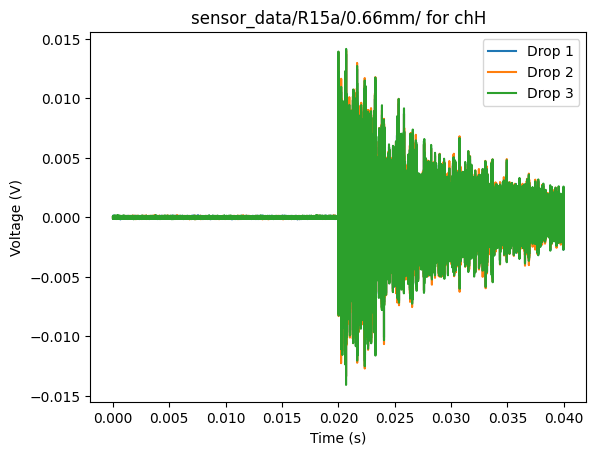

In [10]:
plt.figure(1)
for i in range(data_TS.shape[1]):
    plt.plot(np.arange(0,len(data_TS[:, i]))*data_dt_TS[i], data_TS[:, i], label=f'Drop {i + 1}')

plt.title(f'{data_dir} for {sensor_loc}')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.legend()
plt.show()

# Load SEM data

Map sensor location to SEM file

In [11]:
print('*** Working on {:s} ***'.format(SEM_dir))

# Dictionary mapping for sensor locations
sensor_data = {
    'chH': {'filename': 'REC.POS90.FXZ.semv', 'angle': 90, 'xdist': 0, 'zdist': 'modelh_p'},
    'chG': {'filename': 'REC.POS80.FXZ.semv', 'angle': 80, 'xdist': 'modelh_p', 'zdist': 'modelh_p'},
    'chF': {'filename': 'REC.POS70.FXZ.semv', 'angle': 70, 'xdist': 'modelh_p', 'zdist': 'modelh_p'},
    'chE': {'filename': 'REC.POS60.FXZ.semv', 'angle': 60, 'xdist': 'modelh_p', 'zdist': 'modelh_p'},
    'chD': {'filename': 'REC.POS50.FXZ.semv', 'angle': 50, 'xdist': 'modelh_p', 'zdist': 'modelh_p'},
    'chC': {'filename': 'REC.POS40.FXZ.semv', 'angle': 40, 'xdist': 'modelh_p', 'zdist': 'modelh_p'},
    'chB': {'filename': 'REC.POS30.FXZ.semv', 'angle': 30, 'xdist': 'modelh_p', 'zdist': 'modelh_p'},
    'chA': {'filename': 'REC.POS20.FXZ.semv', 'angle': 20, 'xdist': 'modelh_p', 'zdist': 'modelh_p'},
    'chX': {'filename': 'REC.POS00.FXX.semv', 'angle': 0, 'xdist': 10.5 / 100, 'zdist': 0},
    'chY': {'filename': 'REC.POS00.FXY.semv', 'angle': 0, 'xdist': 10.5 / 100, 'zdist': 0}
}

# Retrieve data based on sensor location
if sensor_loc in sensor_data:
    filename_TL = sensor_data[sensor_loc]['filename']
    zdist = modelh_p if sensor_data[sensor_loc]['zdist'] == 'modelh_p' else sensor_data[sensor_loc]['zdist']

    # Calculate xdist based on angle if present
    angle = sensor_data[sensor_loc]['angle']
    xdist = modelh_p / np.tan(angle * np.pi / 180) if angle else sensor_data[sensor_loc]['xdist']
else:
    raise ValueError(f"Unknown sensor location: {sensor_loc}")

*** Working on SEM_data/ ***


Load SEM data $v_k^{SEM}(x,t)$ for the specified sensor location $x$

In [12]:
t_TL, Green_TL = function_modules.specfem_read(SEM_dir, filename_TL)

Loading SEM_data/REC.POS90.FXZ.semv Done


# Calculate source function from ball properties

*** Calculating source function ***


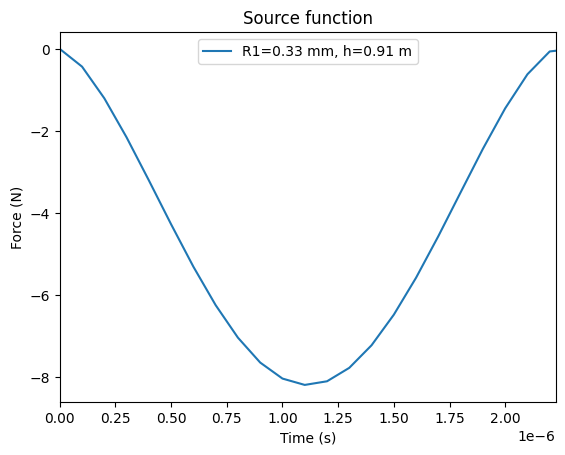

In [13]:
print('*** Calculating source function ***')

# Set the sampling period and frequency
sf = round(1 / data_dt_TS[0])  # Sampling frequency (Hz)
T = 1 / sf  # Time step dt (s)
t0 = round(np.sqrt(xdist ** 2 + zdist ** 2) / (Cp * data_dt_TS[0]))  # Theoretical P Wave arrival time for padding

# Calculate source function ft with minimal sample frequency
sf_min = 1 / ((T_S / data_dt_TS[0] + t0) * data_dt_TS[0])
ft, t, tc = function_modules.ball_impact(
    sf, Rb / 1000, drop_heights[0] / 100, mub, Eb, rhob, mu_p, E_p, sf_min=sf_min
)

# Plot source function
plt.figure(2)
plt.plot(t, -ft, label=f'R1={Rb:.2g} mm, h={drop_heights[0] / 100:.2g} m')
plt.title('Source function')
plt.xlabel('Time (s)')
plt.ylabel('Force (N)')
plt.legend()
plt.xlim([0, tc])
plt.show()

# Low-pass and down-sampling Green's function

In [14]:
print("*** Low-pass and down-sampling Green's function ***")

# Define constants and compute sampling frequency
max_SEM_freq = 1 / 7.6079232e-7  # Max frequency resolution of SEM (Hz)
sampling_freq = 1 / np.diff(t_TL[:2])[0]  # Compute sampling frequency

# Apply low-pass filter to remove high frequencies above SEM mesh resolution
sos = signal.butter(2, max_SEM_freq, 'low', fs=sampling_freq, output='sos')
Green_TL_filtered = signal.sosfilt(sos, Green_TL)

# Display sampling rates
print(f'Lab data sampling rate = {sf} Hz')
specfem_sampling_rate = 1 / (t_TL[2] - t_TL[1])
print(f'SPECFEM3D sampling rate = {specfem_sampling_rate} Hz')

# Calculate downsampling ratio
downsample_ratio = round(specfem_sampling_rate / sf)
print(f'Resampling SPECFEM3D at ratio {specfem_sampling_rate / sf:.2f} ≈ {downsample_ratio}')

# Downsample SPECFEM3D to match lab data sampling rate
t_TL = t_TL[::downsample_ratio]  # Time array downsampled
Green_TL = Green_TL_filtered[::downsample_ratio]  # Downsampled velocity data
dt_TL = 1 / round(1 / (t_TL[2] - t_TL[1]))  # Time step after downsampling

*** Low-pass and down-sampling Green's function ***
Lab data sampling rate = 10000000 Hz
SPECFEM3D sampling rate = 40000000.0 Hz
Resampling SPECFEM3D at ratio 4.00 ≈ 4


# Convolve Green's function with source function to get theoretical displacement

In [15]:
# Convolve source function with Green's function for SEM and trim from first arrival
disp_TL = np.convolve(Green_TL.ravel(), ft.ravel(), mode='full') * dt_TL
disp_TL = disp_TL[t0: t0 + int(T_L / dt_TL)]
disp_TS = disp_TL[: int(T_S / T)]

# Adjust T_L if necessary based on the length of disp_TL
if len(disp_TL) != int(T_L / dt_TL):
    T_L = len(disp_TL) * dt_TL
    print(f'Setting T_L = {T_L}s')

# Prepare final displacement and Green's function arrays for SEM and TS
Green_TL_trim = Green_TL[t0: t0 + int(T_L / dt_TL)]
Green_TS_trim = Green_TL_trim[: int(T_S / T)]

# Trim and zero-pad theoretical displacement

In [16]:
# Apply zero-padding to displacement arrays before the first arrival
disp_TL = function_modules.zeropad_theory(len(disp_TL) * 2, disp_TL)
disp_TS = function_modules.zeropad_theory(len(disp_TS) * 2, disp_TS)

Plot the theoretical displacement \
Due to the floating SEM model a constant drift is present

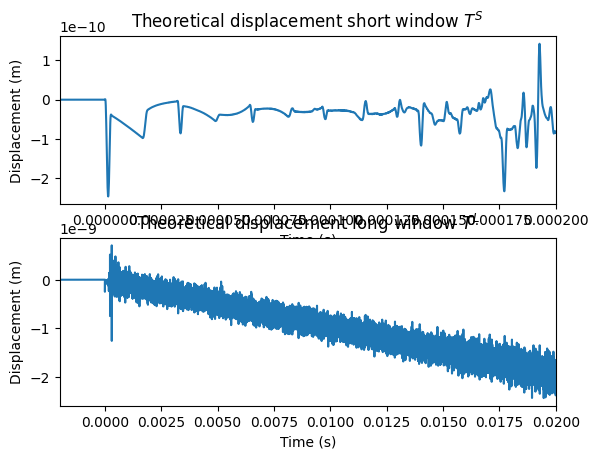

In [17]:
# Plot displacement function
plt.figure(3)
plt.subplot(2, 1, 1)
plt.title('Theoretical displacement short window $T^{S}$')
plt.plot(np.arange(0, len(disp_TS)) / sf - T_S, disp_TS)
plt.xlabel('Time (s)')
plt.ylabel('Displacement (m)')
plt.xlim([-T_S/10, T_S])
plt.subplot(2, 1, 2)
plt.title('Theoretical displacement long window $T^{L}$')
plt.plot(np.arange(0, len(disp_TL)) * dt_TL - T_L, disp_TL)
plt.xlabel('Time (s)')
plt.ylabel('Displacement (m)')
plt.xlim([-T_L/10, T_L])
plt.show()

# Align Sensor trace to SEM trace 

Align first sensor trace to SEM trace

In [18]:
print("*** Aligning data ***")

# Extract sensor type from data directory

sensor = data_dir.split('/')[-3]

# Apply reversed polarity if needed for particular sensor for better alignment
reverse_polarity_sensors = {'R15a', 'R6a', 'R3a', 'S9225'}
data_TS_align = -data_TS[:, 0] if sensor in reverse_polarity_sensors else data_TS[:, 0]

# Align imported data based on T_S displacement
corr_TS, corr_shift_TS = function_modules.corr_align_diff(disp_TS, data_TS_align, sta, lta, trig)

*** Aligning data ***


Re-load sensor data based on first trace to SEM trace offset 

In [19]:
print('Aligning TS Data to SEM')

# Loading .mat data with corrected offset
[data_TS2, data_dt_TS, idx, voltage_range, filenmb, ball_diameters, drop_heights] \
    = function_modules.load_mat(data_dir, sensor_loc, N, T_S*2, sensor_loc[-1],  -corr_shift_TS * T)  # Load .mat files

print(f'Applying {corr_shift_TS * T}s shift to Data')

Aligning TS Data to SEM
Loading sensor_data/R15a/0.66mm/chH-0001.mat Done
Loading sensor_data/R15a/0.66mm/chH-0002.mat Done
Loading sensor_data/R15a/0.66mm/chH-0003.mat Done
Applying 3e-07s shift to Data


# Align all sensor traces among themselves using spatial-distance and correlation

In [20]:
if N > 1:
    print('Aligning Data using spatial-distance')
    [data_aligned_TS, dist, dist_shift, idx_dist] = function_modules.spatial_distance_align(data_TS2,
                                                                                              data_dt_TS,
                                                                                              idx,
                                                                                              data_dir,
                                                                                              sensor_loc,
                                                                                              sensor_loc[-1],
                                                                                              filenmb)  # Align traces based on first traces

    print('Aligning Data using correlation')
    [data_aligned_TS, corr, corr_shift, idx_corr] = function_modules.corr_align_mat(data_aligned_TS,
                                                                                      data_dt_TS, T_S,
                                                                                      idx_dist, T_align,
                                                                                      data_dir,
                                                                                      sensor_loc, sensor_loc[-1],
                                                                                      filenmb)  # Align traces based on first traces

    for i in range(data_TS.shape[1]):
        print(f'Drop {i + 1}: Applying a final {(corr_shift[i] + dist_shift[i]) * T }s offset')

    print('Stacking TS Data')
    [data_stacked_TS, data_std_TS] = function_modules.stack_timeseries(data_aligned_TS,
                                                                         data_dt_TS)  # Stack traces
elif N == 1:

    data_aligned_TS = data_TS2

    print('N=1, no need to stack Data')
    data_stacked_TS = np.ndarray.flatten(data_TS)
    data_std_TS = np.zeros(np.shape(data_stacked_TS))

# Loading .mat data with corrected offset from previous alignment
idx_TL = np.copy(idx_corr)
idx_TS_noise = np.copy(idx_corr)
idx_TL_noise = np.copy(idx_corr)

idx_TL[0, :] = idx_TL[0, :] - int((T_L - T_S) / dt_TL)
idx_TL[1, :] = idx_TL[1, :] + int((T_L - T_S) / dt_TL)

idx_TS_noise[1, :] = idx_TS_noise[0, :] + int(T_S / dt_TL)
idx_TS_noise[0, :] = idx_TS_noise[1, :] - len(disp_TS)

idx_TL_noise[1, :] = idx_TL_noise[0, :] + int(T_S / dt_TL)
idx_TL_noise[0, :] = idx_TL_noise[1, :] - len(disp_TL)

print('Aligning TL Data to SEM')

[data_aligned_TL, data_dt_TL, idx, filenmb] = function_modules.load_mat_idx(data_dir, sensor_loc, N,
                                                                              idx_TL, sensor_loc[-1])

print('Loading short noise window')

[data_aligned_TS_noise, data_dt_TS_noise, idx, filenmb] = function_modules.load_mat_idx(data_dir, sensor_loc,
                                                                                          N,
                                                                                          idx_TS_noise, sensor_loc[-1])

print('Loading long noise window')

[data_aligned_TL_noise, data_dt_TL_noise, idx, filenmb] = function_modules.load_mat_idx(data_dir, sensor_loc,
                                                                                          N,
                                                                                          idx_TL_noise, sensor_loc[-1])

print('Stacking TL Data')

if N > 1:

    [data_stacked_TL, data_std_TL] = function_modules.stack_timeseries(data_aligned_TL,
                                                                         data_dt_TL)  # Stack traces

    [data_stacked_TS_noise, data_std_TS_noise] = function_modules.stack_timeseries(data_aligned_TS_noise,
                                                                                     data_dt_TS_noise)

    [data_stacked_TL_noise, data_std_TL_noise] = function_modules.stack_timeseries(data_aligned_TL_noise,
                                                                                     data_dt_TL_noise)
elif N == 1:

    data_stacked_TL = np.ndarray.flatten(data_aligned_TL)
    data_std_TL = np.zeros(np.shape(data_stacked_TL))

    data_stacked_TS_noise = np.ndarray.flatten(data_aligned_TS_noise)
    data_std_TS_noise = np.zeros(np.shape(data_stacked_TS_noise))

    data_stacked_TL_noise = np.ndarray.flatten(data_aligned_TL_noise)
    data_std_TL_noise = np.zeros(np.shape(data_stacked_TL_noise))

Aligning Data using spatial-distance
Loading sensor_data/R15a/0.66mm/chH-0001.mat Done
Loading sensor_data/R15a/0.66mm/chH-0002.mat Done
Loading sensor_data/R15a/0.66mm/chH-0003.mat Done
Aligning Data using correlation
Loading sensor_data/R15a/0.66mm/chH-0001.mat Done
Loading sensor_data/R15a/0.66mm/chH-0002.mat Done
Loading sensor_data/R15a/0.66mm/chH-0003.mat Done
Drop 1: Applying a final 0.0s offset
Drop 2: Applying a final 0.0s offset
Drop 3: Applying a final 0.0s offset
Stacking TS Data
Aligning TL Data to SEM
Loading sensor_data/R15a/0.66mm/chH-0001.mat Done
Loading sensor_data/R15a/0.66mm/chH-0002.mat Done
Loading sensor_data/R15a/0.66mm/chH-0003.mat Done
Loading short noise window
Loading sensor_data/R15a/0.66mm/chH-0001.mat Done
Loading sensor_data/R15a/0.66mm/chH-0002.mat Done
Loading sensor_data/R15a/0.66mm/chH-0003.mat Done
Loading long noise window
Loading sensor_data/R15a/0.66mm/chH-0001.mat Done
Loading sensor_data/R15a/0.66mm/chH-0002.mat Done
Loading sensor_data/R15a/0

Plot the aligned waveforms and final stack

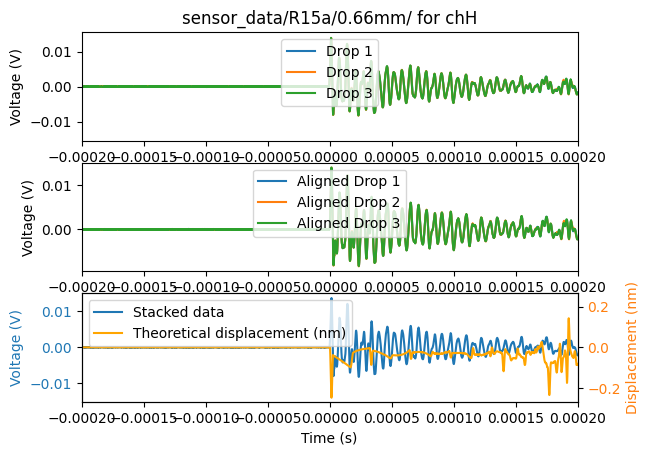

In [21]:
plt.figure(4)
plt.subplot(3, 1, 1)
for i in range(data_TS.shape[1]):
    plt.plot(np.arange(-len(data_TS[:, i])/2, len(data_TS[:, i])/2) * data_dt_TS[i], data_TS[:, i], label=f'Drop {i + 1}')
plt.title(f'{data_dir} for {sensor_loc}')
plt.ylabel('Voltage (V)')
plt.xlim([-T_S, T_S])
plt.legend()

plt.subplot(3, 1, 2)
for i in range(data_aligned_TS.shape[1]):
    plt.plot(np.arange(-len(data_aligned_TS[:, i])/2, len(data_aligned_TS[:, i])/2) * data_dt_TS[i], data_aligned_TS[:, i], label=f'Aligned Drop {i + 1}')
plt.ylabel('Voltage (V)')
plt.xlim([-T_S, T_S])
plt.legend()

ax1 = plt.subplot(3, 1, 3)
lns1 = ax1.plot(np.arange(-len(data_stacked_TS)/2, len(data_stacked_TS)/2) * T, data_stacked_TS, label='Stacked data')
lns11 = ax1.fill_between(np.arange(-len(data_stacked_TS)/2, len(data_stacked_TS)/2) * T,
                 data_stacked_TS-data_std_TS,
                 data_stacked_TS+data_std_TS,
                 alpha=0.1)
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Voltage (V)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
lns2 = ax2.plot(np.arange(-len(disp_TS)/2, len(disp_TS)/2) * dt_TL, disp_TS * 1E9, color='orange', label='Theoretical displacement (nm)')
ax2.set_ylabel('Displacement (nm)', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')
plt.xlim([-T_S, T_S])

mpl_axes_aligner.align.yaxes(ax1, 0, ax2, 0, 0.5)
lns = lns1 + lns2
labs = [l.get_label() for l in lns]
ax2.legend(lns, labs)
plt.show()

# Apply a Blackman-Harris window

In [22]:
print('Applying Blackman-Harris window')

# Apply to TS data
bh_filter_TS = signal.windows.blackmanharris(len(disp_TS))
disp_TS_bh = np.multiply(disp_TS, bh_filter_TS)
t_TS = np.arange(0, len(disp_TS_bh)) * T - len(disp_TS_bh) / 2 * T  # Time

lab_TS_bh = np.multiply(data_stacked_TS, bh_filter_TS)
data_std_TS_bh = np.multiply(data_std_TS, bh_filter_TS)
lab_noise_TS_bh = np.multiply(data_stacked_TS_noise, bh_filter_TS)

# Apply to TL data
bh_filter_TL = signal.windows.blackmanharris(len(disp_TL))  # Blackman-Harris window
disp_TL_bh = np.multiply(disp_TL, bh_filter_TL)
t_TL = np.arange(0, len(disp_TL)) * dt_TL - len(disp_TL) / 2 * dt_TL  # Time

lab_TL_bh = np.multiply(data_stacked_TL, bh_filter_TL)
data_std_TL_bh = np.multiply(data_std_TL, bh_filter_TL)
lab_noise_TL_bh = np.multiply(data_stacked_TL_noise, bh_filter_TL)  # Noise window for SEM lab data

Applying Blackman-Harris window


# Apply the Fast Fourier Transform

In [23]:
print('Applying FFT')

Ffft = fft(-ft, len(ft))  # Force-function fft for TS
Ffreq = fftfreq(len(ft), 1 / sf)

Sfft_TS = fft(lab_TS_bh, len(lab_TS_bh))  # lab signal voltage fft TS
Sfft_std_TS = np.sqrt(sum((data_std_TS_bh)*np.conjugate(data_std_TS_bh)))
Sfft_std_TS = Sfft_std_TS + Sfft_std_TS*1j
Sfreq_TS = fftfreq(len(lab_TS_bh), 1 / sf)

Sfft_TL = fft(lab_TL_bh, len(lab_TL_bh))  # lab signal voltage fft TL
Sfft_std_TL = np.sqrt(sum((data_std_TL_bh) * np.conjugate(data_std_TL_bh)))
Sfft_std_TL = Sfft_std_TL + Sfft_std_TL * 1j
Sfreq_TL = fftfreq(len(lab_TL_bh), dt_TL)

Nfft_TS = fft(lab_noise_TS_bh, len(lab_noise_TS_bh))  # lab noise voltage fft TS
Nfreq_TS = fftfreq(len(lab_noise_TS_bh), 1 / sf)

Nfft_TL = fft(lab_noise_TL_bh, len(lab_noise_TL_bh))  # lab noise voltage fft TL
Nfreq_TL = fftfreq(len(lab_noise_TL_bh), dt_TL)

Uw_TS = fft(disp_TS_bh, len(disp_TS_bh))  # displacement fft TS
Ufefreq_TS = fftfreq(len(disp_TS), 1 / sf)

Uw_TL = fft(disp_TL_bh, len(disp_TL_bh))  # displacement fft TL
Ufefreq_TL = fftfreq(len(disp_TL_bh), dt_TL)

Applying FFT


# Calculate the Instrument response and Error

In [24]:
print('Calculating Instrument response and Error')

Iw_TS = Sfft_TS / Uw_TS  # Instrument response fft TS
Iw_std_TS = Sfft_std_TS / abs(Uw_TS)

Iw_TL = Sfft_TL / Uw_TL  # Instrument response fft TL
Iw_std_TL = Sfft_std_TL / abs(Uw_TL)

Calculating Instrument response and Error


Save output as `.pickle` for `instrument_response_stitch.py`

In [25]:
print('Saving outputs')

data = {
    'Iw_TS': Iw_TS,
    'Iw_TL': Iw_TL,
    'Uw_TS': Uw_TS,
    'Uw_TL': Uw_TL,
    'Sfft_TS': Sfft_TS,
    'Sfreq_TS': Sfreq_TS,
    'Sfft_TL': Sfft_TL,
    'Sfreq_TL': Sfreq_TL,

    'Nfft_TS': Nfft_TS,
    'Nfreq_TS': Nfreq_TS,
    'Nfft_TL': Nfft_TL,
    'Nfreq_TL': Nfreq_TL,

    'Iw_std_TS': Iw_std_TS,
    'Iw_std_TL': Iw_std_TL,
    'Sfft_std_TS': Sfft_std_TS,
    'Sfft_std_TL': Sfft_std_TL,

    'tc': tc,
    'T_S': T_S,
    'T_L': T_L,
    'sensor_loc': sensor_loc,
    'data_dir': data_dir,
    'sf': sf,
    'Rb': Rb,

    'data_aligned_TS': data_aligned_TS,
    'data_stacked_TS': data_stacked_TS,
    'data_std_TS': data_std_TS,
    'data_aligned_TL': data_aligned_TL,
    'data_stacked_TL': data_stacked_TL,
    'data_std_TL': data_std_TL,

    'disp_TL': disp_TL,
    'disp_TS': disp_TS,
}

pathlib.Path('out').mkdir(exist_ok=True)  # Make output directory if doesn't exist

with open('{:s}/{:s}_{:.2f}mm_{:s}.pickle'.format('out', sensor, Rb*2, sensor_loc), 'wb') as f:
    pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)

Saving outputs


# Plot figures

Plot all lab data traces and stacked trace

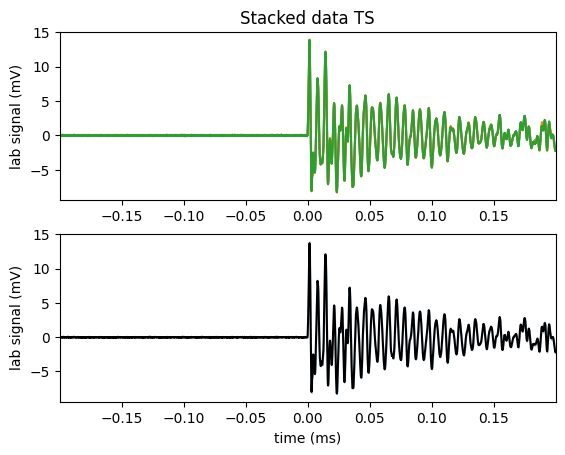

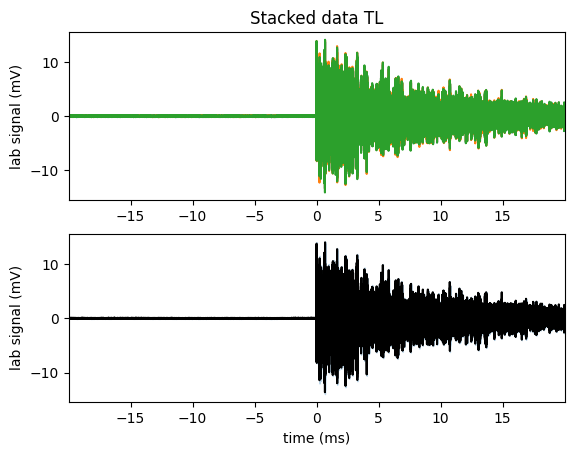

In [26]:
### Plot all lab data traces, stacked trace ###
plt.figure(5)
plt.subplot(211)
for i in range(data_TS.shape[1]):
    plt.plot(t_TS * 10 ** 3, data_aligned_TS[:, i] * 1E3)

plt.ylabel('lab signal (mV)')
plt.title('Stacked data TS')
plt.xlim((-max(t_TS) * 10 ** 3, max(t_TS) * 10 ** 3))

plt.subplot(212)
plt.plot(t_TS * 10 ** 3, data_stacked_TS * 1E3, color='k')
plt.fill_between(t_TS * 10 ** 3, (data_stacked_TS + data_std_TS) * 1E3,
                 (data_stacked_TS - data_std_TS) * 1E3,
                 color='C0', alpha=0.3)

plt.ylabel('lab signal (mV)')
plt.xlabel('time (ms)')
plt.xlim((-max(t_TS) * 10 ** 3, max(t_TS) * 10 ** 3))
plt.show()

plt.figure(6)
plt.subplot(211)
for i in range(data_TS.shape[1]):
    plt.plot(t_TL * 10 ** 3, data_aligned_TL[:, i] * 1E3)

plt.ylabel('lab signal (mV)')
plt.title('Stacked data TL')
plt.xlim((-max(t_TL) * 10 ** 3, max(t_TL) * 10 ** 3))

plt.subplot(212)
plt.plot(t_TL * 10 ** 3, data_stacked_TL * 1E3, color='k')
plt.fill_between(t_TL * 10 ** 3, (data_stacked_TL + data_std_TL) * 1E3,
                 (data_stacked_TL - data_std_TL) * 1E3,
                 color='C0', alpha=0.3)
plt.ylabel('lab signal (mV)')
plt.xlabel('time (ms)')
plt.xlim((-max(t_TL) * 10 ** 3, max(t_TL) * 10 ** 3))
plt.show()

Plot zoomed stacked data and theoretical displacement

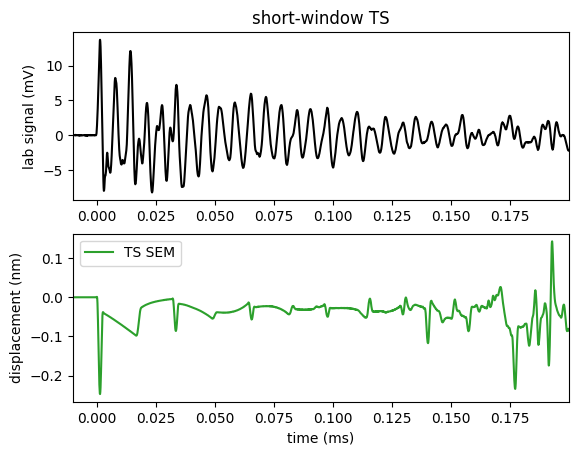

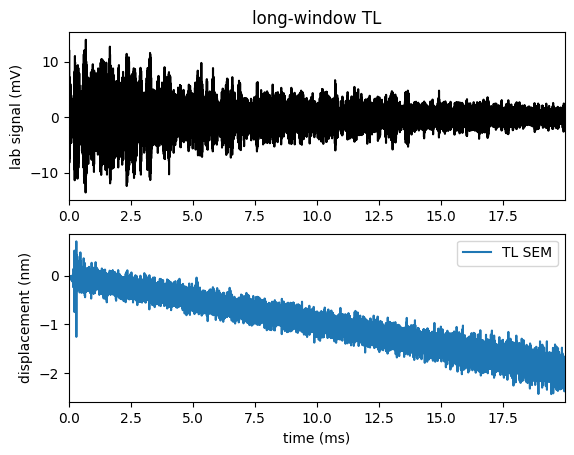

In [27]:
### Plot Zoomed stacked data and TS ###
plt.figure(7)
plt.subplot(211)
plt.plot(t_TS * 10 ** 3, data_stacked_TS * 1E3, color='k')
plt.ylabel('lab signal (mV)')
plt.title('short-window TS')
plt.xlim((-0.01, max(t_TS) * 10 ** 3))

plt.subplot(212)
plt.plot(t_TS * 10 ** 3, disp_TS * 10 ** 9, color='tab:green', label='TS SEM')
plt.xlabel('time (ms)')
plt.ylabel('displacement (nm)')
plt.legend()
plt.xlim((-0.01, max(t_TS) * 10 ** 3))
plt.show()

### Plot Zoomed stacked data and TL ###
plt.figure(8)
plt.subplot(211)
plt.plot(t_TL * 10 ** 3, data_stacked_TL * 1E3, color='k')
plt.ylabel('lab signal (mV)')
plt.title('long-window TL')
plt.xlim((-0.01, max(t_TL) * 10 ** 3))

plt.subplot(212)
plt.plot(t_TL * 10 ** 3, disp_TL * 10 ** 9, color='tab:blue', label='TL SEM')
plt.xlabel('time (ms)')
plt.ylabel('displacement (nm)')
plt.legend()
plt.xlim((-0.01, max(t_TL) * 10 ** 3))
plt.show()

Plot zoomed data after Blackman-Harris window

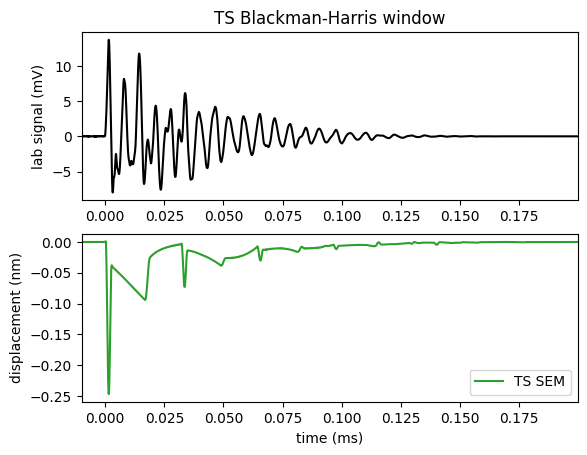

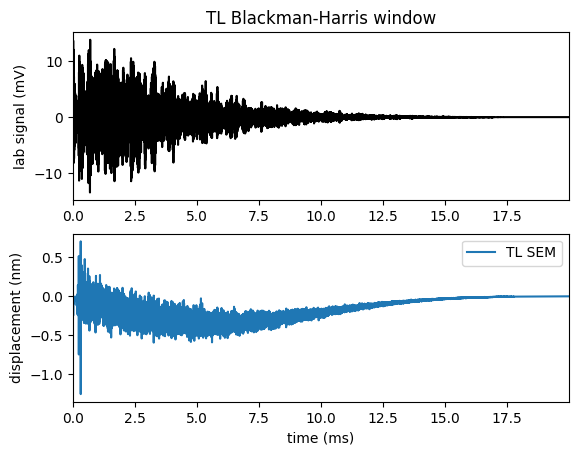

In [28]:
### Plot Zoomed TS data after BH window ###
plt.figure(9)
plt.subplot(211)
plt.plot(t_TS * 10 ** 3, lab_TS_bh * 1E3, color='k', label='Balldrop')
plt.ylabel('lab signal (mV)')
plt.title('TS Blackman-Harris window')
plt.xlim((-0.01, max(t_TS) * 10 ** 3))

plt.subplot(212)
plt.plot(t_TS * 10 ** 3, disp_TS_bh * 10 ** 9, color='tab:green', label='TS SEM')
plt.xlabel('time (ms)')
plt.ylabel('displacement (nm)')
plt.legend()
plt.xlim((-0.01, max(t_TS) * 10 ** 3))
plt.show()

### Plot Zoomed TL data after BH window ###
plt.figure(10)
plt.subplot(211)
plt.plot(t_TL * 10 ** 3, lab_TL_bh * 1E3, color='k')
plt.ylabel('lab signal (mV)')
plt.title('TL Blackman-Harris window')
plt.xlim((-0.01, max(t_TL) * 10 ** 3))

plt.subplot(212)
plt.plot(t_TL * 10 ** 3, disp_TL_bh * 10 ** 9, color='tab:blue', label='TL SEM')
plt.xlabel('time (ms)')
plt.ylabel('displacement (nm)')
plt.legend()
plt.xlim((-0.01, max(t_TL) * 10 ** 3))
plt.show()

Plot short window and long window and lab data zoomed out (zero-pad)

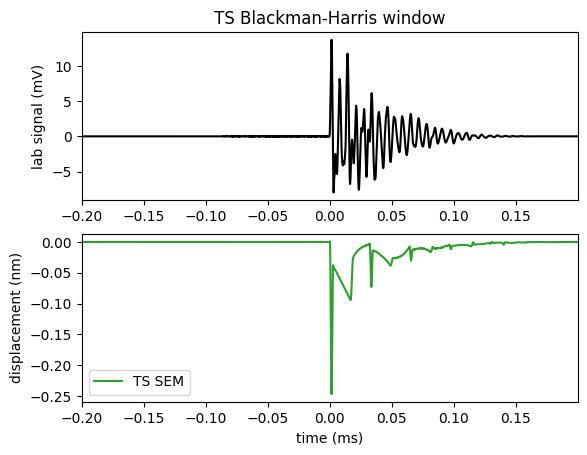

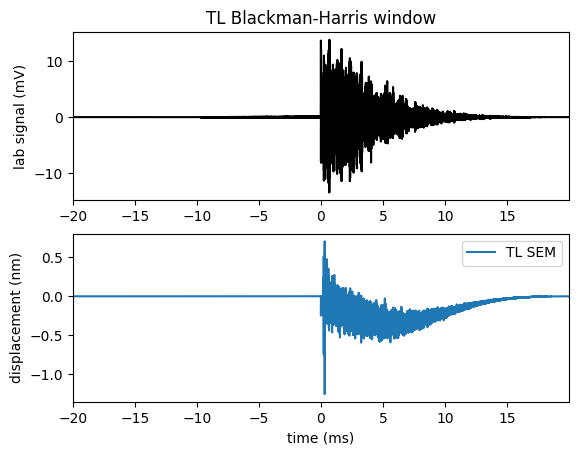

In [29]:
### Plot TL and lab data zoomed out (zero-pad) ###
plt.figure(11)
plt.subplot(211)
plt.plot(t_TS * 10 ** 3, lab_TS_bh * 1E3, color='k')
plt.ylabel('lab signal (mV)')
plt.title('TS Blackman-Harris window')
plt.autoscale(enable=True, axis='x', tight=True)

plt.subplot(212)
plt.plot(t_TS * 10 ** 3, disp_TS_bh * 10 ** 9, color='tab:green', label='TS SEM')
plt.xlabel('time (ms)')
plt.ylabel('displacement (nm)')
plt.legend()
plt.autoscale(enable=True, axis='x', tight=True)
plt.show()

### Plot TL and lab data zoomed out (zero-pad) ###
plt.figure(12)
plt.subplot(211)
plt.plot(t_TL * 10 ** 3, lab_TL_bh * 1E3, color='k')
plt.ylabel('lab signal (mV)')
plt.title('TL Blackman-Harris window')
plt.autoscale(enable=True, axis='x', tight=True)

plt.subplot(212)
plt.plot(t_TL * 10 ** 3, disp_TL_bh * 10 ** 9, color='tab:blue', label='TL SEM')
plt.xlabel('time (ms)')
plt.ylabel('displacement (nm)')
plt.legend()
plt.autoscale(enable=True, axis='x', tight=True)
plt.show()

Plot noise window

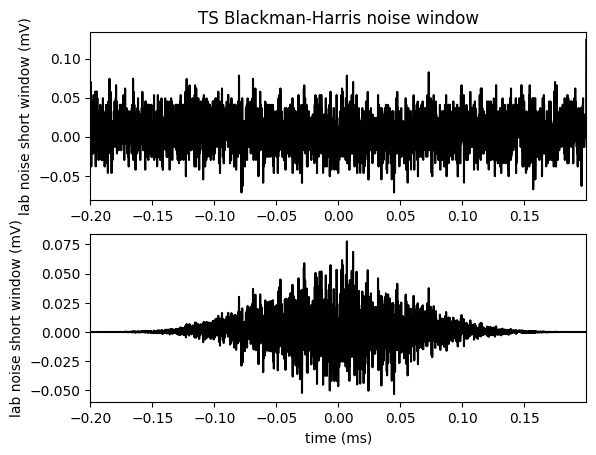

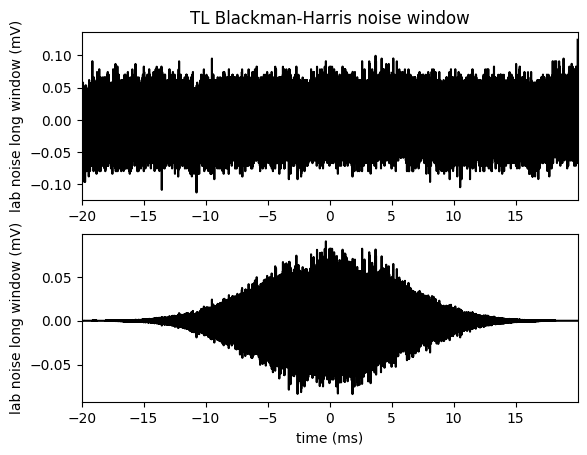

In [30]:
plt.figure(13)
plt.subplot(211)
plt.plot(t_TS * 10 ** 3, data_stacked_TS_noise * 1E3, color='k')
plt.ylabel('lab noise short window (mV)')
plt.title('TS Blackman-Harris noise window')
plt.autoscale(enable=True, axis='x', tight=True)

plt.subplot(212)
plt.plot(t_TS * 10 ** 3, lab_noise_TS_bh * 1E3, color='k')
plt.xlabel('time (ms)')
plt.ylabel('lab noise short window (mV)')
plt.autoscale(enable=True, axis='x', tight=True)
plt.show()

plt.figure(14)
plt.subplot(211)
plt.plot(t_TL * 10 ** 3, data_stacked_TL_noise * 1E3, color='k')
plt.ylabel('lab noise long window (mV)')
plt.title('TL Blackman-Harris noise window')
plt.autoscale(enable=True, axis='x', tight=True)

plt.subplot(212)
plt.plot(t_TL * 10 ** 3, lab_noise_TL_bh * 1E3, color='k')
plt.xlabel('time (ms)')
plt.ylabel('lab noise long window (mV)')
plt.autoscale(enable=True, axis='x', tight=True)
plt.show()

Plot lab data and force function FFT

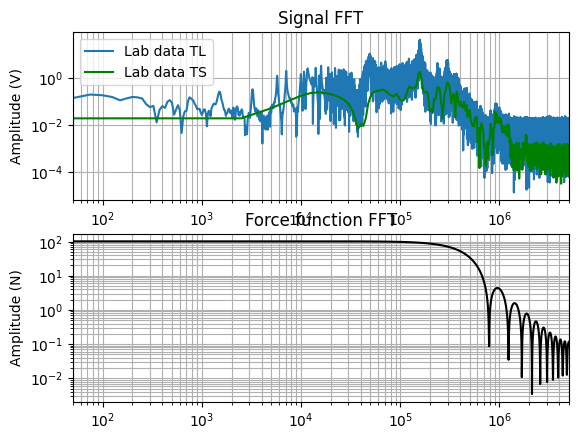

In [31]:
plt.figure(15)
plt.subplot(211)
plt.plot(Sfreq_TL[0:int(len(Sfreq_TL) / 2)], abs(Sfft_TL[0:int(len(Sfreq_TL) / 2)]), color='tab:blue',
         label='Lab data TL')
plt.plot(Sfreq_TS[0:int(len(Sfreq_TS) / 2)], abs(Sfft_TS[0:int(len(Sfreq_TS) / 2)]), color='g',
         label='Lab data TS')
plt.title('Signal FFT')
plt.ylabel('Amplitude (V)')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlim(1 / T_L, (1 / dt_TL) / 2)
plt.grid(True, which='both')

plt.subplot(212)
plt.plot(Ffreq[0:int(len(Ffreq) / 2)], abs(Ffft[0:int(len(Ffreq) / 2)]), color='k')
plt.title('Force function FFT')
plt.ylabel('Amplitude (N)')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1 / T_L, (1 / dt_TL) / 2)
plt.grid(True, which='both')
plt.show()

Plot instrument response for short and long window with error as shaded area \
Note the log-log scale

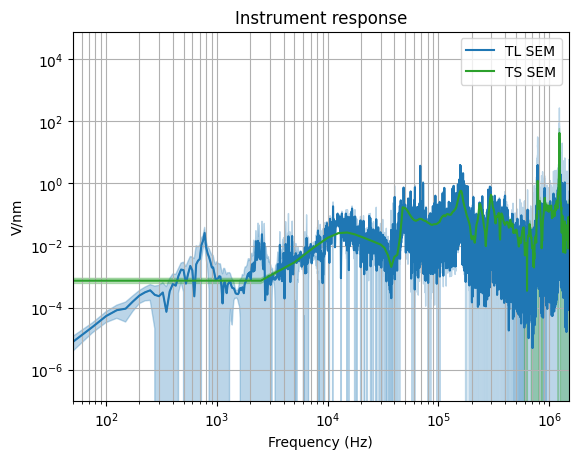

In [32]:
### TS and TL Instrument response ###
plt.figure(16)
plt.plot(Sfreq_TL[0:int(len(Sfreq_TL) / 2)], abs(Iw_TL[0:int(len(Sfreq_TL) / 2)]/1E9),
         label='TL SEM',
         color='tab:blue')
plt.fill_between(Sfreq_TL[0:int(len(Sfreq_TL) / 2)],
                 abs(Iw_TL[0:int(len(Sfreq_TL) / 2)]/1E9) + abs(Iw_std_TL[0:int(len(Sfreq_TL) / 2)]/1E9),
                 abs(Iw_TL[0:int(len(Sfreq_TL) / 2)]/1E9),
                 color='tab:blue',
                 alpha=0.3)
plt.fill_between(Sfreq_TL[0:int(len(Sfreq_TL) / 2)],
                 abs(Iw_TL[0:int(len(Sfreq_TL) / 2)]/1E9) - abs(Iw_std_TL[0:int(len(Sfreq_TL) / 2)]/1E9),
                 abs(Iw_TL[0:int(len(Sfreq_TL) / 2)]/1E9),
                 color='tab:blue',
                 alpha=0.3)
plt.plot(Sfreq_TS[0:int(len(Sfreq_TS) / 2)], abs(Iw_TS[0:int(len(Sfreq_TS) / 2)]/1E9),
         label='TS SEM', color='tab:green')
plt.fill_between(Sfreq_TS[0:int(len(Sfreq_TS) / 2)],
                 abs(Iw_TS[0:int(len(Sfreq_TS) / 2)]/1E9) + abs(Iw_std_TS[0:int(len(Sfreq_TS) / 2)]/1E9),
                 abs(Iw_TS[0:int(len(Sfreq_TS) / 2)]/1E9),
                 color='tab:green',
                 alpha=0.3)
plt.fill_between(Sfreq_TS[0:int(len(Sfreq_TS) / 2)],
                 abs(Iw_TS[0:int(len(Sfreq_TS) / 2)]/1E9) - abs(Iw_std_TS[0:int(len(Sfreq_TS) / 2)]/1E9),
                 abs(Iw_TS[0:int(len(Sfreq_TS) / 2)]/1E9),
                 color='tab:green',
                 alpha=0.3)
plt.title('Instrument response')
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('V/nm')
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which='both')
plt.xlim(1 / T_L, 1.5E6)
plt.show()

Plot lab data FFT with uncertainty as shaded area

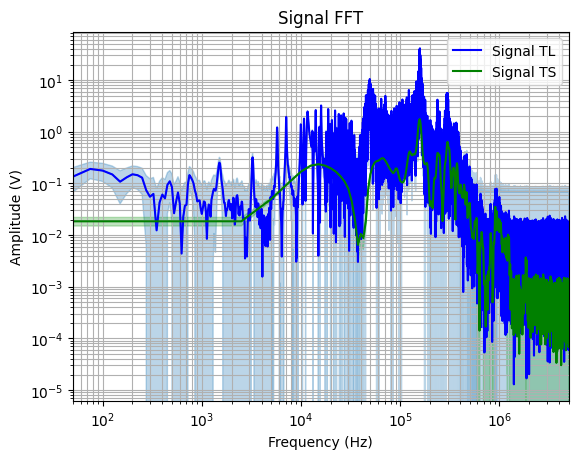

In [33]:
### Lab data FFT ###
plt.figure(17)
plt.plot(Sfreq_TL[0:int(len(Sfreq_TL) / 2)], abs(Sfft_TL[0:int(len(Sfreq_TL) / 2)]),
         label='Signal TL', color='b')
plt.plot(Sfreq_TS[0:int(len(Sfreq_TS) / 2)], abs(Sfft_TS[0:int(len(Sfreq_TS) / 2)]),
         label='Signal TS', color='g')
plt.fill_between(Sfreq_TL[0:int(len(Sfreq_TL) / 2)],
                 abs(Sfft_TL[0:int(len(Sfreq_TL) / 2)]) + abs(Sfft_std_TL),
                 abs(Sfft_TL[0:int(len(Sfreq_TL) / 2)]),
                 color='tab:blue',
                 alpha=0.3)
plt.fill_between(Sfreq_TL[0:int(len(Sfreq_TL) / 2)],
                 abs(Sfft_TL[0:int(len(Sfreq_TL) / 2)]) - abs(Sfft_std_TL),
                 abs(Sfft_TL[0:int(len(Sfreq_TL) / 2)]),
                 color='tab:blue',
                 alpha=0.3)
plt.fill_between(Sfreq_TS[0:int(len(Sfreq_TS) / 2)],
                 abs(Sfft_TS[0:int(len(Sfreq_TS) / 2)]) + abs(Sfft_std_TS),
                 abs(Sfft_TS[0:int(len(Sfreq_TS) / 2)]),
                 color='tab:green',
                 alpha=0.3)
plt.fill_between(Sfreq_TS[0:int(len(Sfreq_TS) / 2)],
                 abs(Sfft_TS[0:int(len(Sfreq_TS) / 2)]) - abs(Sfft_std_TS),
                 abs(Sfft_TS[0:int(len(Sfreq_TS) / 2)]),
                 color='tab:green',
                 alpha=0.3)
plt.title('Signal FFT')
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (V)')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1 / T_L, (1 / dt_TL) / 2)
plt.grid(True, which='both')
plt.show()

Plot both lab data and theoretical data FFT \
Note double y-axis

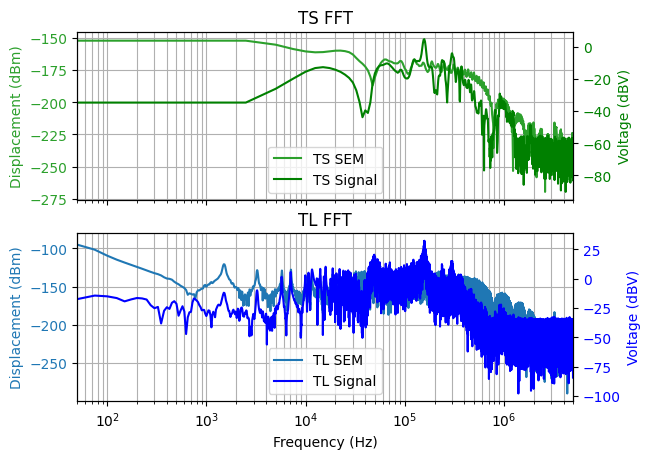

In [34]:
### Lab data FFT ###

fig, axs = plt.subplots(2, 1, sharex=True)

# First subplot (TS FFT)
ax1 = axs[0]
ln1 = ax1.plot(
    Ufefreq_TS[:len(Ufefreq_TS) // 2],
    20 * np.log10(np.abs(Uw_TS[:len(Uw_TS) // 2])),
    label='TS SEM', color='tab:green'
)
ax1.set_ylabel('Displacement (dBm)', color='tab:green')
ax1.tick_params(axis='y', labelcolor='tab:green')

ax2 = ax1.twinx()
ln2 = ax2.plot(
    Sfreq_TS[:len(Sfreq_TS) // 2],
    20 * np.log10(np.abs(Sfft_TS[:len(Sfreq_TS) // 2])),
    label='TS Signal', color='g', zorder=1.9,
)
ax2.set_ylabel('Voltage (dBV)', color='g')
ax2.tick_params(axis='y', labelcolor='g')

lns = ln1 + ln2
labs = [l.get_label() for l in lns]
ax2.legend(lns, labs, loc='lower center')

ax1.set_title('TS FFT')
ax1.set_xscale('log')
ax1.set_xlim(1 / T_L, (1 / dt_TL) / 2)
ax1.grid(True, which='both')

# Second subplot (TL FFT)
ax1 = axs[1]
ln1 = ax1.plot(
    Ufefreq_TL[:len(Ufefreq_TL) // 2],
    20 * np.log10(np.abs(Uw_TL[:len(Uw_TL) // 2])),
    label='TL SEM', color='tab:blue', zorder=2.01
)
ax1.set_ylabel('Displacement (dBm)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ln2 = ax2.plot(
    Sfreq_TL[:len(Sfreq_TL) // 2],
    20 * np.log10(np.abs(Sfft_TL[:len(Sfreq_TL) // 2])),
    label='TL Signal', color='b', zorder=1.9,
)
ax2.set_ylabel('Voltage (dBV)', color='b')
ax2.tick_params(axis='y', labelcolor='b')

lns = ln1 + ln2
labs = [l.get_label() for l in lns]
ax2.legend(lns, labs, loc='lower center')

ax1.set_title('TL FFT')
ax1.set_xlabel('Frequency (Hz)')
ax1.set_xscale('log')
ax1.set_xlim(1 / T_L, (1 / dt_TL) / 2)
ax1.grid(True, which='both')

# Adjust layout
plt.show()

Plot lab data and noise for short and long windows

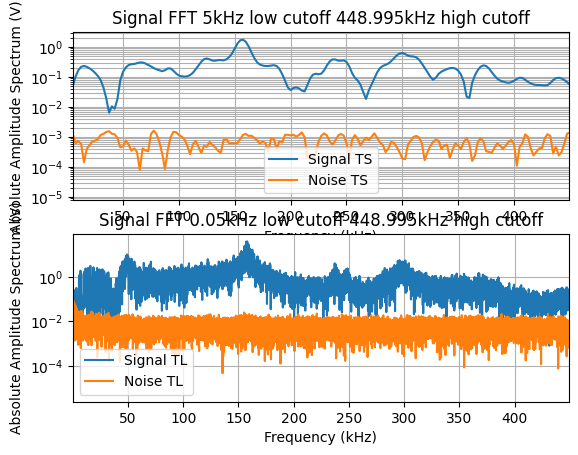

In [35]:
### Lab data and noise for TS and TL ###
plt.figure(18)
plt.subplot(211)
plt.plot(Sfreq_TS[0:int(len(Sfreq_TS) / 2)] / 1E3, abs(Sfft_TS[0:int(len(Sfreq_TS) / 2)]),
         label='Signal TS')
plt.plot(Nfreq_TS[0:int(len(Nfreq_TS) / 2)] / 1E3, abs(Nfft_TS[0:int(len(Nfreq_TS) / 2)]),
         label='Noise TS')
plt.title('Signal FFT {:g}kHz low cutoff {:g}kHz high cutoff'.format(1 / (T_S) / 1E3, (1 / tc) / 1E3))
plt.legend()
plt.xlabel('Frequency (kHz)')
plt.ylabel('Absolute Amplitude Spectrum (V)')
plt.yscale('log')
plt.xlim(((1 / (T_S)) / 1E3, (1 / tc) / 1E3))
plt.grid(True, which='both')

plt.subplot(212)
plt.plot(Sfreq_TL[0:int(len(Sfreq_TL) / 2)] / 1E3, (abs(Sfft_TL[0:int(len(Sfreq_TL) / 2)])),
         label='Signal TL')
plt.plot(Nfreq_TL[0:int(len(Nfreq_TL) / 2)] / 1E3, (abs(Nfft_TL[0:int(len(Nfreq_TL) / 2)])),
         label='Noise TL')
plt.title('Signal FFT {:g}kHz low cutoff {:g}kHz high cutoff'.format(1 / T_L / 1E3, (1 / tc) / 1E3))
plt.legend()
plt.xlabel('Frequency (kHz)')
plt.ylabel('Absolute Amplitude Spectrum (V)')
plt.yscale('log')
plt.xlim(((1 / T_L) / 1E3, (1 / tc) / 1E3))
plt.grid(True, which='both')
plt.show()